In [1]:
__author__ = "Jakob Aungiers"
__copyright__ = "Jakob Aungiers 2018"
__version__ = "2.0.0"
__license__ = "MIT"

import os
import json
import time
import math
import matplotlib.pyplot as plt
from core.data_processor import DataLoader
from core.model import Model

Using TensorFlow backend.


In [2]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)
        plt.legend()
    plt.show()

In [3]:
if __name__ == '__main__':
    configs = json.load(open('config.json', 'r'))
    if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])
    #  Setting pyplot fig size
    plt.rcParams['figure.figsize'] = [10, 8]

    data = DataLoader(
        os.path.join('data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )
    model.model.summary()

[Model] Model Compiled
Time taken: 0:00:00.955568
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 100)           41200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 202,101
Trainable params: 202,101
Non-trainable params: 0
____________________

In [4]:
    '''
	# in-memory training
	model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
	)
	'''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )



[Model] Training Started
[Model] 2 epochs, 32 batch size, 90 batches per epoch
Epoch 1/2
90/90 [==============================] - 9s 96ms/step - loss: 0.0023
Epoch 2/2
90/90 [==============================] - 7s 76ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/27032019-032555-e2.h5
Time taken: 0:00:20.050940


[Model] Predicting Sequences Multiple...


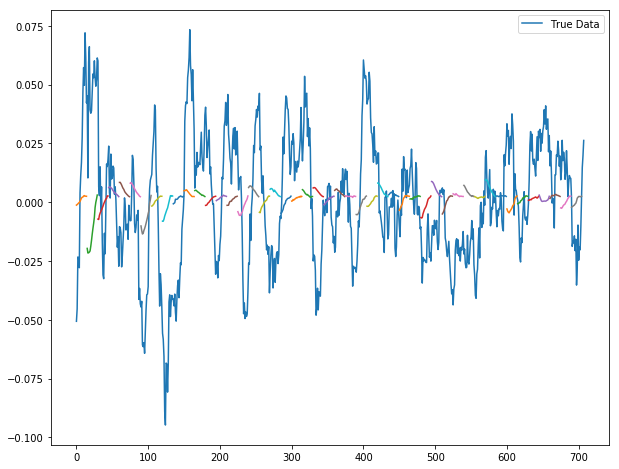

[Model] Predicting Sequences Multiple...


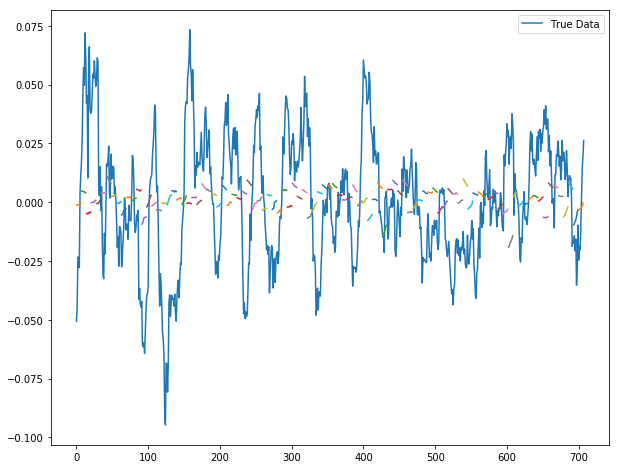

[Model] Predicting Sequences Full...


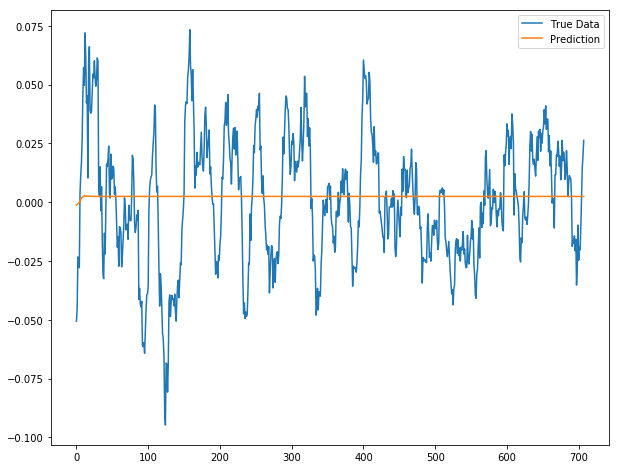

[Model] Predicting Point-by-Point...


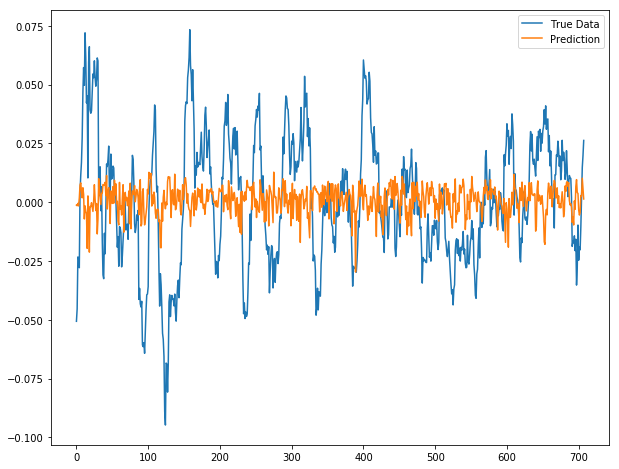

In [5]:
    x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise'])
    
    predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
    plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
    
    predictions_m7 = model.predict_sequences_multiple(x_test, 7, 7)
    plot_results_multiple(predictions_m7, y_test, 7)
    
    predictions_f = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
    plot_results(predictions_f, y_test)
    
    predictions_p = model.predict_point_by_point(x_test)
    plot_results(predictions_p, y_test)